# Building Data Genome Project 2.0
## Breakout visualization

Biam! (pic.biam@gmail.com)

In [1]:
# data and numbers
import numpy as np
import pandas as pd
import datetime as dt

# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

import gc

In [2]:
path = "..//data//meters//screening//breakout//"
path1 = "..//data//meters//screening//breakout_plots//"

# Introduction

In this notebook visualization plots of number of breakouts will de made.<br>
For breakouts detection in the raw meters dataset was used the [Breakout Detection package](https://github.com/twitter/BreakoutDetection) developed by Twitter, choosing 168 points (a week) as minimum to define a gap. A brief introduction about this package can be found [here](https://blog.twitter.com/engineering/en_us/a/2014/breakout-detection-in-the-wild.html). Cleaned meter data (outliers and 24hs zero readings removed) are used for this analysis. This was implemented in R language, the process can be found [here](https://github.com/buds-lab/building-data-genome-project-2/blob/master/notebooks/08_BreakOut-detection.Rmd)

# Functions

In [3]:
def plotHeatmap(df, metername):
    numberofplots = 1
    fig = plt.figure(figsize=(10,15))
    #plt.rc('ytick', labelsize=yfont)

    # Get the data
    x = mdates.drange(df.columns[0], df.columns[-1] + dt.timedelta(hours=1), dt.timedelta(hours=1))
    #y = df.index
    y = np.linspace(0, len(df), len(df)+1)

    # Plot
    ax = fig.add_subplot(numberofplots, 1, 1)

    data = np.array(df)

    cmap = plt.get_cmap('flag')

    qmesh = ax.pcolormesh(x, y, data, cmap=cmap, rasterized=True)

    cbaxes = fig.add_axes([0.13, 0.1, 0.77, 0.02]) 
    cbar = fig.colorbar(qmesh, ax=ax, orientation='horizontal', cax = cbaxes)
    cbar.ax.tick_params(length = 0)
    tick_locator = ticker.MaxNLocator()
    cbar.locator = tick_locator
    cbar.update_ticks()
    cbar.set_label('Breakout phase order')

    ax.axis('tight')

    # Set up as dates
    ax.xaxis_date()
    #ax.yaxis.set_ticks()
    fig.autofmt_xdate()
    fig.subplots_adjust(hspace=.5)

    ax.set_xlabel("Timeline", fontsize=16)
    ax.set_ylabel("Building", fontsize=16)
    ax.set_title(str(metername) +" breakouts", fontdict={'fontsize':20},
)
    #plt.tight_layout()
    plt.subplots_adjust(bottom=0.17)
    
    return fig

In [4]:
def processData(metername):
    # load breakout df
    df_bo = pd.read_csv(path + metername + "_breakout.csv")
    # Transform timestamp to datetime object type
    df_bo["timestamp"] = pd.to_datetime(df_bo["timestamp"], format='%Y-%m-%d %H:%M:%S')
    # Remove timezone offset at the end of timestamp
    df_bo["timestamp"] = df_bo.timestamp.apply(lambda d: d.replace(tzinfo=None))
    
    # Tag gaps
    for col in df_bo.columns[2:]:
        # Label breakout point in consequtive numbers
        df_bo[col] = list(pd.factorize(df_bo[col])[0])
        # Replace label -1 with nan
        df_bo.loc[df_bo[col] == -1, col] = np.nan
        # Tag all timestamps with the breakout gap to it belongs
        df_bo[col].fillna(inplace=True, method="bfill")
        # Tag remaining rows
        df_bo[col].fillna(value = df_bo[col].max()+1,inplace=True)

    # Drop useless column
    df_bo = df_bo.drop("RelativeTime", axis=1).set_index("timestamp")
    # Fill nan left
    df_bo = df_bo.fillna(0)
    # Sort rows
    df_bo = df_bo.T.loc[df_bo.T.sum(axis=1).sort_values(ascending=True).index]
    
    return df_bo

# Datasets for plotting

Create datasets for plotting and export them.

In [5]:
metername = ["electricity","water","chilledwater","hotwater","gas", "steam","solar","irrigation"]

for i in metername:
    df = processData(i)
    df.to_csv(path1 + i + "_BOdata.csv", index=False)

# One figure to subplot them all

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


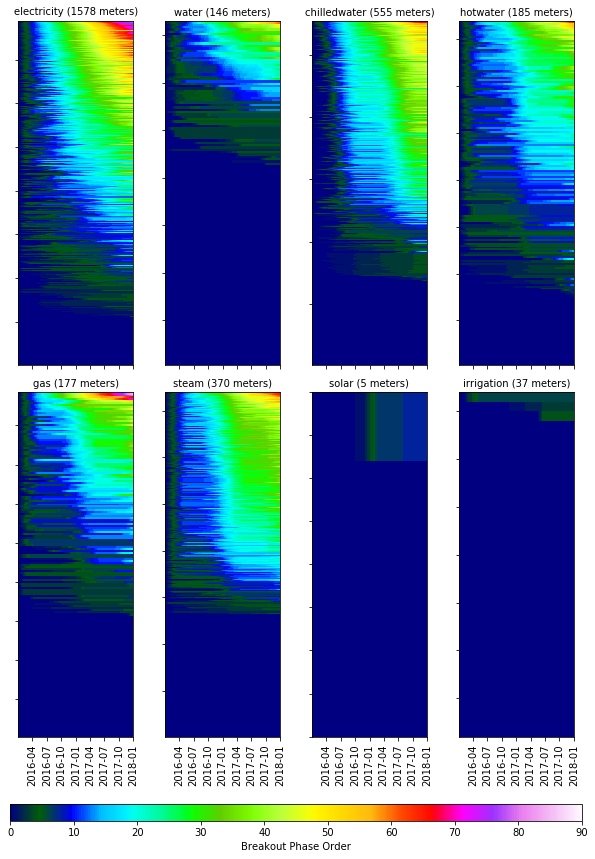

In [7]:
fig, axes = plt.subplots(2, 4, sharex = True, figsize=(8.27,11.69))
axes = axes.flatten()

metername = ["electricity","water","chilledwater","hotwater","gas", "steam","solar","irrigation"]

for i,j in enumerate(metername):
    
    #df = processData(j)
    df = pd.read_csv(path1 + j + "_BOdata.csv")
    df.columns = pd.to_datetime(df.columns, format='%Y-%m-%d %H:%M:%S')
    
    # Get the data
    x = mdates.drange(df.columns[1], df.columns[-1] + dt.timedelta(hours=1), dt.timedelta(hours=1))
    y = np.linspace(1, len(df), len(df)+1)
    
    # Plot
    ax = axes[i]
    data = np.array(df)
    cmap = plt.get_cmap('gist_ncar')
    qmesh = ax.pcolormesh(x, y, data, cmap=cmap, rasterized=True, vmin=0, vmax=90)
        
    # Axis
    ax.axis('tight')  
    ax.xaxis_date() # Set up as dates
    ax.tick_params("x", labelrotation=90)
    ax.set_yticklabels([])
    ax.set_title(j + " (" + str(int(max(y))) + " meters)", fontdict={'fontsize':10})
    
"""    # Colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(qmesh, cax=cax, orientation='vertical')"""
    
# Color bar  
cbaxes = fig.add_axes([0.025, 0.02, 0.96, 0.02]) 
cbar = fig.colorbar(qmesh, ax=ax, orientation='horizontal', cax = cbaxes)
cbar.set_label('Breakout Phase Order')

plt.tight_layout()
plt.subplots_adjust(bottom=0.12)

In [8]:
fig.savefig("..\\figures\\breakOut_all.jpg", dpi=300, bbox_inches='tight')

# Bibliography

- Miller, Clayton & Schlueter, Arno. (2015). Forensically discovering simulation feedback knowledge from a campus energy information system. 10.13140/RG.2.1.2286.0964. 